**Datasets:**

- **SVT**: [Street View Text Dataset](https://www.kaggle.com/datasets/nageshsingh/the-street-view-text-dataset)
- **USPS**: [USPS Dataset](https://www.kaggle.com/datasets/bistaumanga/usps-dataset)
- **Synthetic Digits**: [Synthetic Digits Dataset](https://www.kaggle.com/datasets/prasunroy/synthetic-digits)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from PIL import Image
import requests
import zipfile

In [2]:
# Function to display images
def display_image(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
# Image Generator Model
class ImageGenerator(nn.Module):
    def __init__(self):
        super(ImageGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Image Discriminator Model
class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

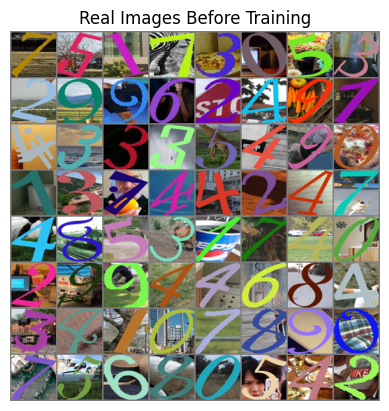

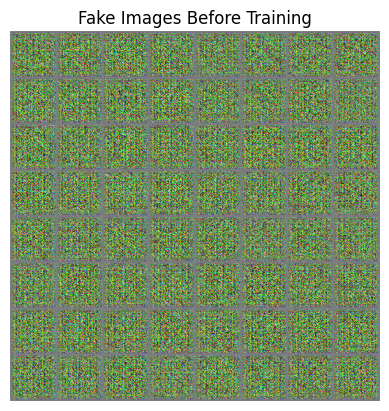

Epoch 1 - Discriminator Loss: 1.4204 Generator Loss: 1.9398
Epoch 1 - Discriminator Loss: 2.3156 Generator Loss: 1.1651
Epoch 1 - Discriminator Loss: 1.6183 Generator Loss: 0.8033
Epoch 1 - Discriminator Loss: 1.7434 Generator Loss: 0.7995
Epoch 2 - Discriminator Loss: 1.6739 Generator Loss: 0.7493
Epoch 2 - Discriminator Loss: 1.4944 Generator Loss: 0.6487
Epoch 2 - Discriminator Loss: 1.6412 Generator Loss: 1.0122
Epoch 2 - Discriminator Loss: 1.4303 Generator Loss: 0.8400
Epoch 3 - Discriminator Loss: 1.3551 Generator Loss: 0.7717
Epoch 3 - Discriminator Loss: 1.2491 Generator Loss: 0.8824
Epoch 3 - Discriminator Loss: 1.3972 Generator Loss: 0.7446
Epoch 3 - Discriminator Loss: 1.3083 Generator Loss: 0.9217
Epoch 4 - Discriminator Loss: 1.4275 Generator Loss: 0.7337
Epoch 4 - Discriminator Loss: 1.4507 Generator Loss: 0.8174
Epoch 4 - Discriminator Loss: 1.3473 Generator Loss: 0.7798
Epoch 4 - Discriminator Loss: 1.3263 Generator Loss: 0.8175
Epoch 5 - Discriminator Loss: 1.3909 Gen

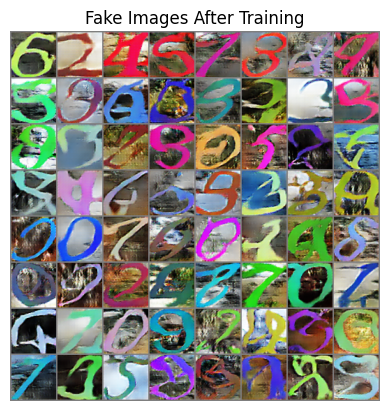

✅ Model Accuracy: 81.35% (1627/2000 correct predictions)


In [4]:
# Custom Dataset for Synthetic Digits
class SyntheticDigitsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_dataset()

    def load_dataset(self):
        data_path = os.path.join(self.root, "imgs_train")
        for label in os.listdir(data_path):
            label_path = os.path.join(data_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    self.data.append(img_path)
                    self.labels.append(int(label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB').resize((64, 64))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None
        
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
image_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load Dataset
dataset = SyntheticDigitsDataset(root='/home/ngreenberg/.cache/kagglehub/datasets/prasunroy/synthetic-digits/versions/1/synthetic_digits', transform=image_transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

# Initialize Models and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator, discriminator = ImageGenerator().to(device), ImageDiscriminator().to(device)

loss_function = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

# Generate and show images before training
real_images, _ = next(iter(data_loader))
display_image(utils.make_grid(real_images[:64]), title="Real Images Before Training")

fixed_noise = torch.randn(64, 100, 1, 1, device=device)
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()
    display_image(utils.make_grid(fake_images), title="Fake Images Before Training")

# Training loop
num_epochs = 35
real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    for batch_idx, (real_data, _) in enumerate(data_loader):
        ############################
        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        real_data = real_data.to(device)
        batch_size = real_data.size(0)
        
        # Train Discriminator
        discriminator.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_data)
        errD_real = loss_function(output, label)
        errD_real.backward()

        noise_input = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_data = generator(noise_input)
        label.fill_(fake_label)
        output = discriminator(fake_data.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        discriminator_optimizer.step()

        # Train Generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_data)
        errG = loss_function(output, label)
        errG.backward()
        generator_optimizer.step()

        # Print training progress
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch+1} - Discriminator Loss: {errD_real.item() + errD_fake.item():.4f} '
                  f'Generator Loss: {errG.item():.4f}')

# Generate images after training
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()
    display_image(utils.make_grid(fake_images), title="Fake Images After Training")

generator.eval()
discriminator.eval()

# Generate fake images
fixed_noise = torch.randn(1000, 100, 1, 1, device=device)
fake_images = generator(fixed_noise)  # Use 'generator' instead of 'netG'

# Get real images
real_images, _ = next(iter(DataLoader(dataset, batch_size=1000, shuffle=True)))
real_images = real_images.to(device)

# Get predictions
with torch.no_grad():
    real_preds = discriminator(real_images).squeeze()  # Use 'discriminator' instead of 'netD'
    fake_preds = discriminator(fake_images).squeeze()

# Convert to binary classification (0 or 1)
real_correct = (real_preds > 0.5).sum().item()
fake_correct = (fake_preds < 0.5).sum().item()

# Define total correct and total samples
total_correct = real_correct + fake_correct
total_samples = len(real_images) + len(fake_images)

accuracy = (total_correct / total_samples) * 100  # Compute accuracy

# Correct print statement
print(f"✅ Model Accuracy: {accuracy:.2f}% ({total_correct}/{total_samples} correct predictions)")

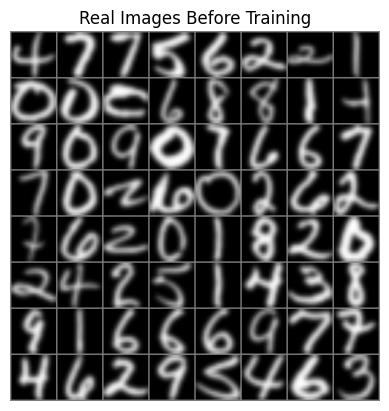

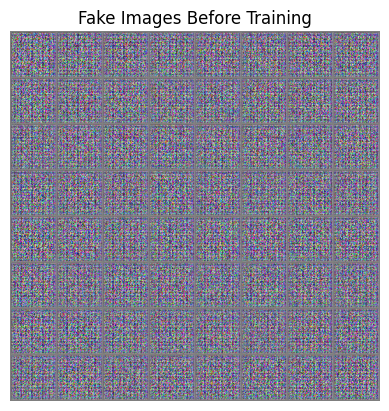

Epoch 1 - Discriminator Loss: 1.2134 Generator Loss: 2.1676
Epoch 1 - Discriminator Loss: 1.3147 Generator Loss: 1.0865
Epoch 2 - Discriminator Loss: 1.3489 Generator Loss: 5.0309
Epoch 2 - Discriminator Loss: 1.3484 Generator Loss: 0.5912
Epoch 3 - Discriminator Loss: 1.4141 Generator Loss: 1.4120
Epoch 3 - Discriminator Loss: 1.6248 Generator Loss: 0.7487
Epoch 4 - Discriminator Loss: 1.1913 Generator Loss: 1.0329
Epoch 4 - Discriminator Loss: 1.3861 Generator Loss: 1.0061
Epoch 5 - Discriminator Loss: 1.3719 Generator Loss: 0.9272
Epoch 5 - Discriminator Loss: 1.4196 Generator Loss: 2.1481
Epoch 6 - Discriminator Loss: 1.2437 Generator Loss: 0.8487
Epoch 6 - Discriminator Loss: 1.2601 Generator Loss: 1.1220
Epoch 7 - Discriminator Loss: 1.2207 Generator Loss: 1.7656
Epoch 7 - Discriminator Loss: 1.3804 Generator Loss: 1.2798
Epoch 8 - Discriminator Loss: 1.2838 Generator Loss: 0.9507
Epoch 8 - Discriminator Loss: 1.2753 Generator Loss: 1.0324
Epoch 9 - Discriminator Loss: 1.6415 Gen

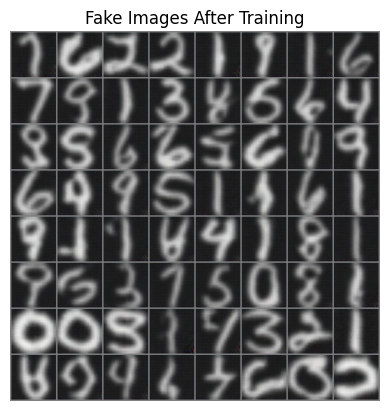

✅ Model Accuracy: 73.90% (1478/2000 correct predictions)


In [7]:
# USPS Dataset
# Transformations
image_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load USPS dataset
dataset = datasets.USPS(root='./data', train=True, download=True, transform=image_transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator, discriminator = ImageGenerator().to(device), ImageDiscriminator().to(device)

loss_function = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Pre-training visualization
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
def visualize(title, images):
    display_image(utils.make_grid(images.cpu()), title=title)

real_images, _ = next(iter(data_loader))
visualize("Real Images Before Training", real_images[:64])
visualize("Fake Images Before Training", generator(fixed_noise).detach())

# Training Loop
num_epochs = 35
real_label, fake_label = 1, 0

for epoch in range(num_epochs):
    for batch_idx, (real_data, _) in enumerate(data_loader, start=1):
        ############################
        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        batch_size = real_data.size(0)
        real_data = real_data.to(device)
        label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

        
        # Train Discriminator
        discriminator.zero_grad()
        errD_real = loss_function(discriminator(real_data), label_real)
        errD_real.backward()
        
        noise_input = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_data = generator(noise_input)
        errD_fake = loss_function(discriminator(fake_data.detach()), label_fake)
        errD_fake.backward()
        discriminator_optimizer.step()
        
        # Train Generator
        generator.zero_grad()
        errG = loss_function(discriminator(fake_data), label_real)
        errG.backward()
        generator_optimizer.step()
        
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch+1} - Discriminator Loss: {errD_real.item() + errD_fake.item():.4f} '
                  f'Generator Loss: {errG.item():.4f}')

# Post-training visualization
with torch.no_grad():
    visualize("Fake Images After Training", generator(fixed_noise))

# Model Evaluation
# Model Evaluation
generator.eval()
discriminator.eval()

# Generate fake images
fixed_noise = torch.randn(1000, 100, 1, 1, device=device)
fake_images = generator(fixed_noise)  # Use 'generator' instead of 'netG'

# Get real images
real_images, _ = next(iter(DataLoader(dataset, batch_size=1000, shuffle=True)))
real_images = real_images.to(device)

# Get predictions
with torch.no_grad():
    real_preds = discriminator(real_images).squeeze()  # Use 'discriminator' instead of 'netD'
    fake_preds = discriminator(fake_images).squeeze()

# Convert to binary classification (0 or 1)
real_correct = (real_preds > 0.5).sum().item()
fake_correct = (fake_preds < 0.5).sum().item()

# Define total correct and total samples
total_correct = real_correct + fake_correct
total_samples = len(real_images) + len(fake_images)

accuracy = (total_correct / total_samples) * 100  # Compute accuracy

# Correct print statement
print(f"✅ Model Accuracy: {accuracy:.2f}% ({total_correct}/{total_samples} correct predictions)")

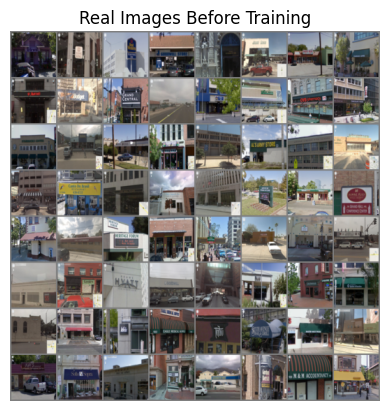

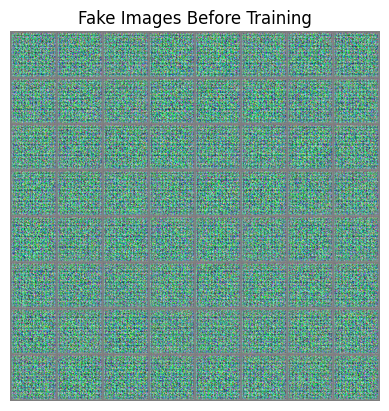

Epoch 1 - Discriminator Loss: 1.3976 Generator Loss: 3.2044
Epoch 2 - Discriminator Loss: 0.3430 Generator Loss: 6.1691
Epoch 3 - Discriminator Loss: 0.2667 Generator Loss: 9.4412
Epoch 4 - Discriminator Loss: 0.0856 Generator Loss: 14.5835
Epoch 5 - Discriminator Loss: 0.0571 Generator Loss: 12.5232
Epoch 6 - Discriminator Loss: 0.0489 Generator Loss: 12.3733
Epoch 7 - Discriminator Loss: 0.0477 Generator Loss: 13.5750
Epoch 8 - Discriminator Loss: 0.0176 Generator Loss: 9.5794
Epoch 9 - Discriminator Loss: 0.0634 Generator Loss: 12.7333
Epoch 10 - Discriminator Loss: 1.1853 Generator Loss: 18.5286
Epoch 11 - Discriminator Loss: 0.0153 Generator Loss: 12.5842
Epoch 12 - Discriminator Loss: 0.0218 Generator Loss: 14.3519
Epoch 13 - Discriminator Loss: 0.3845 Generator Loss: 18.5853
Epoch 14 - Discriminator Loss: 0.0251 Generator Loss: 11.1795
Epoch 15 - Discriminator Loss: 0.5953 Generator Loss: 13.5450
Epoch 16 - Discriminator Loss: 1.3327 Generator Loss: 13.0960
Epoch 17 - Discrimina

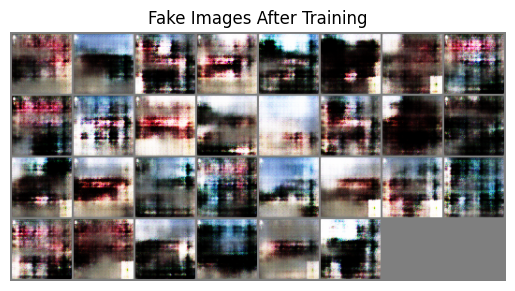

✅ Model Accuracy: 25.93% (350/1350 correct predictions)


In [6]:
# Define the path to your dataset
image_directory = '/home/ngreenberg/.cache/kagglehub/datasets/nageshsingh/the-street-view-text-dataset/versions/1/img'

# Custom Dataset for SVT Images
class StreetViewDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, image) for image in os.listdir(directory) if image.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        else:
            # Default transformation: resize to 64x64
            default_transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            image = default_transform(image)
        
        return image

# Transformations
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Initialize Dataset and DataLoader
dataset = StreetViewDataset(directory=image_directory, transform=image_transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# Initialize models, optimizers, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ImageGenerator().to(device)
discriminator = ImageDiscriminator().to(device)

loss_function = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Generate images BEFORE training
real_images_batch = next(iter(data_loader))
display_image(utils.make_grid(real_images_batch[:64]), title="Real Images Before Training")

noise_input = torch.randn(64, 100, 1, 1, device=device)
with torch.no_grad():
    fake_images_batch = generator(noise_input).detach().cpu()
    display_image(utils.make_grid(fake_images_batch), title="Fake Images Before Training")

# Training loop
epochs = 100
real_label = 1
fake_label = 0

for epoch in range(epochs):
    for batch_idx, data_batch in enumerate(data_loader, 0):
        ############################
        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        discriminator.zero_grad()
        real_data = data_batch.to(device)
        batch_size = real_data.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        real_output = discriminator(real_data)
        real_loss = loss_function(real_output, real_labels)
        real_loss.backward()
        D_real = real_output.mean().item()

        # Train with all-fake batch
        noise_input = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_data = generator(noise_input)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        fake_output = discriminator(fake_data.detach())
        fake_loss = loss_function(fake_output, fake_labels)
        fake_loss.backward()
        D_fake = fake_output.mean().item()
        discriminator_loss = real_loss + fake_loss
        discriminator_optimizer.step()

        # Train Generator
        generator.zero_grad()
        real_labels.fill_(real_label)
        generator_output = discriminator(fake_data)
        generator_loss = loss_function(generator_output, real_labels)
        generator_loss.backward()
        generator_optimizer.step()

        # Print training progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1} - Discriminator Loss: {discriminator_loss.item():.4f} '
                  f'Generator Loss: {generator_loss.item():.4f}')

# Generate images AFTER training
with torch.no_grad():
    fake_images_batch = generator(noise_input).detach().cpu()
    display_image(utils.make_grid(fake_images_batch), title="Fake Images After Training")

# Model Evaluation
generator.eval()
discriminator.eval()

# Generate fake images for evaluation
evaluation_noise = torch.randn(1000, 100, 1, 1, device=device)
generated_images = generator(evaluation_noise)

# Get real images
real_images_batch = next(iter(DataLoader(dataset, batch_size=1000, shuffle=True)))
real_images_batch = real_images_batch.to(device)

# Get predictions from the discriminator
with torch.no_grad():
    real_predictions = torch.sigmoid(discriminator(real_images_batch)).squeeze()
    fake_predictions = torch.sigmoid(discriminator(generated_images)).squeeze()

# Convert to binary classification (0 or 1)
correct_real_predictions = (real_predictions > 0.5).sum().item()
correct_fake_predictions = (fake_predictions <= 0.5).sum().item()

total_samples = len(real_images_batch) + len(generated_images)
accuracy = (correct_real_predictions + correct_fake_predictions) / total_samples * 100

# Print final accuracy
print(f"✅ Model Accuracy: {accuracy:.2f}% ({correct_real_predictions + correct_fake_predictions}/{total_samples} correct predictions)") 